# Porto Seguro’s Safe Driver Prediction

### Load python packages needed for analysis

In [1]:
%pylab inline

#working with the numbers
import numpy as np
import pandas as pd
#visualization
import seaborn as sns
sns.set(style="whitegrid")
import missingno as msn
#machine learning
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn import svm

import xgboost as xgb
import lightgbm as lgb

#other
import time
import datetime
import gc

Populating the interactive namespace from numpy and matplotlib


### Load the datasets

In [2]:
df_train = pd.read_csv(r"input\train.csv")
df_test = pd.read_csv(r"input\test.csv")

print("Train data:")
print("Columns: {}".format(len(df_train.columns)))
print("Rows: {}". format(len(df_train)))
print("Test data:")
print("Columns: {}".format(len(df_test.columns)))
print("Rows: {}". format(len(df_test)))

Train data:
Columns: 59
Rows: 595212
Test data:
Columns: 58
Rows: 892816


In [3]:
display(df_train.head())
display(df_test.head())

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,7,0,2,2,5,1,0,0,1,0,...,9,1,5,8,0,1,1,0,0,1
1,9,0,1,1,7,0,0,0,0,1,...,3,1,1,9,0,1,1,0,1,0
2,13,0,5,4,9,1,0,0,0,1,...,4,2,7,7,0,1,1,0,1,0
3,16,0,0,1,2,0,0,1,0,0,...,2,2,4,9,0,0,0,0,0,0
4,17,0,0,2,0,1,0,1,0,0,...,3,1,1,3,0,0,0,1,1,0


,id,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,...,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,0,0,1,8,1,0,0,1,0,0,...,1,1,1,12,0,1,1,0,0,1
1,1,4,2,5,1,0,0,0,0,1,...,2,0,3,10,0,0,1,1,0,1
2,2,5,1,3,0,0,0,0,0,1,...,4,0,2,4,0,0,0,0,0,0
3,3,0,1,6,0,0,1,0,0,0,...,5,1,0,5,1,0,1,0,0,0
4,4,5,1,7,0,0,0,0,0,1,...,4,0,0,4,0,1,1,0,0,1


### According to data describtion:


"*In this competition, you will predict the probability that an auto insurance policy holder files a claim.
In the train and test data, features that belong to similar groupings are tagged as such in the feature names (e.g., ind, reg, car, calc). In addition, feature names include the postfix **bin** to indicate **binary features** and **cat** to indicate **categorical features**. Features without these designations are either continuous or ordinal. Values of **-1 indicate** that the feature was **missing** from the observation. The target columns signifies whether or not a claim was filed for that policy holder.*"


In [4]:
df_train.dtypes 

id                  int64
target              int64
ps_ind_01           int64
ps_ind_02_cat       int64
ps_ind_03           int64
ps_ind_04_cat       int64
ps_ind_05_cat       int64
ps_ind_06_bin       int64
ps_ind_07_bin       int64
ps_ind_08_bin       int64
ps_ind_09_bin       int64
ps_ind_10_bin       int64
ps_ind_11_bin       int64
ps_ind_12_bin       int64
ps_ind_13_bin       int64
ps_ind_14           int64
ps_ind_15           int64
ps_ind_16_bin       int64
ps_ind_17_bin       int64
ps_ind_18_bin       int64
ps_reg_01         float64
ps_reg_02         float64
ps_reg_03         float64
ps_car_01_cat       int64
ps_car_02_cat       int64
ps_car_03_cat       int64
ps_car_04_cat       int64
ps_car_05_cat       int64
ps_car_06_cat       int64
ps_car_07_cat       int64
ps_car_08_cat       int64
ps_car_09_cat       int64
ps_car_10_cat       int64
ps_car_11_cat       int64
ps_car_11           int64
ps_car_12         float64
ps_car_13         float64
ps_car_14         float64
ps_car_15   

### Let's start by looking a little bit a the distribution of the data and missing entries.

In [5]:
df_train2 = df_train.replace(-1, np.NaN)
df_test2 = df_test.replace(-1, np.NaN)

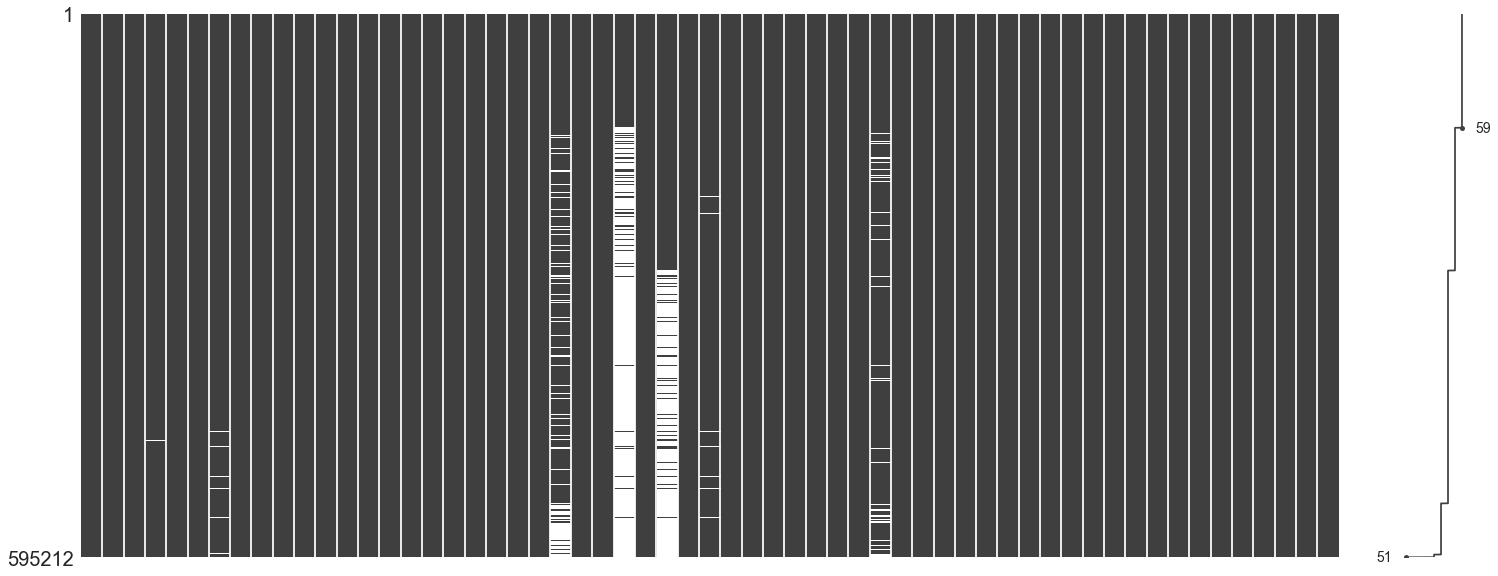

In [6]:
sorted_traindata = msn.nullity_sort(df_train2, sort='descending')
msn.matrix(sorted_traindata)

C:\Users\Wegee\Anaconda3\lib\site-packages\seaborn\matrix.py:143: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
C:\Users\Wegee\Anaconda3\lib\site-packages\seaborn\matrix.py:151: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


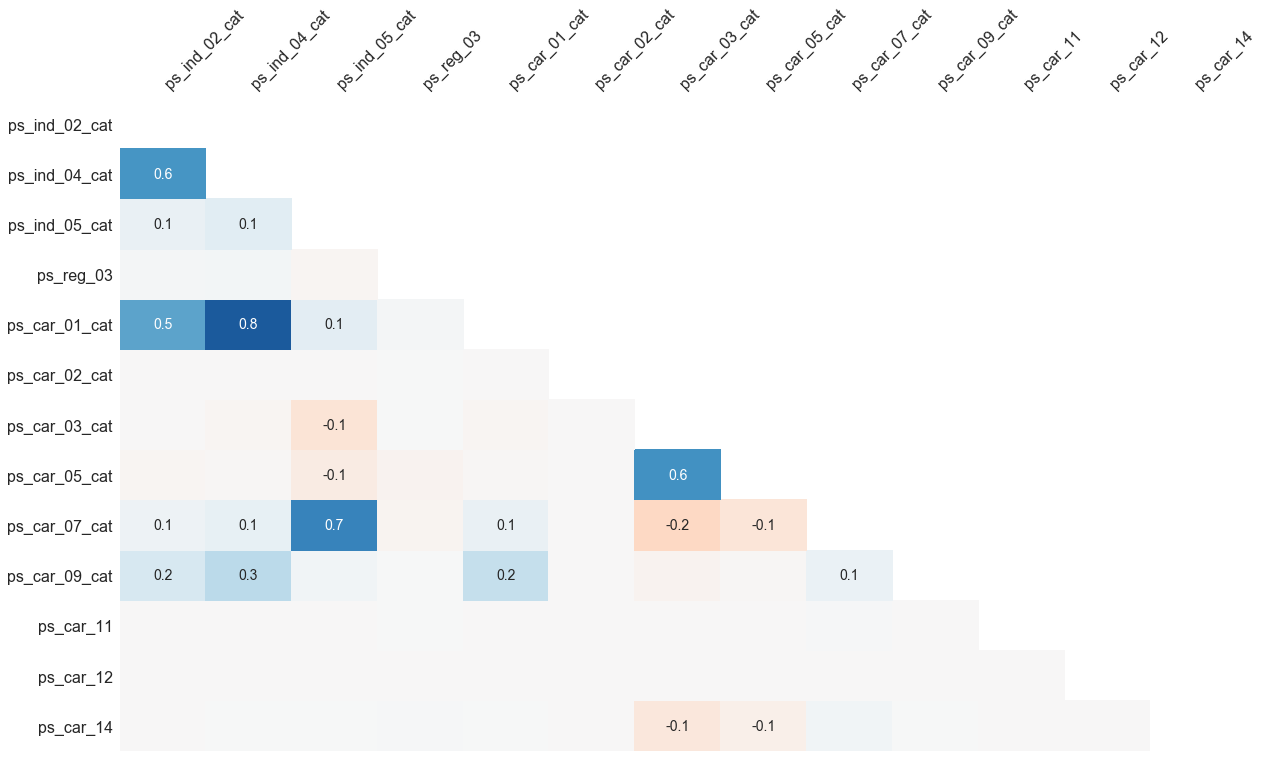

In [7]:
msn.heatmap(df_train2)

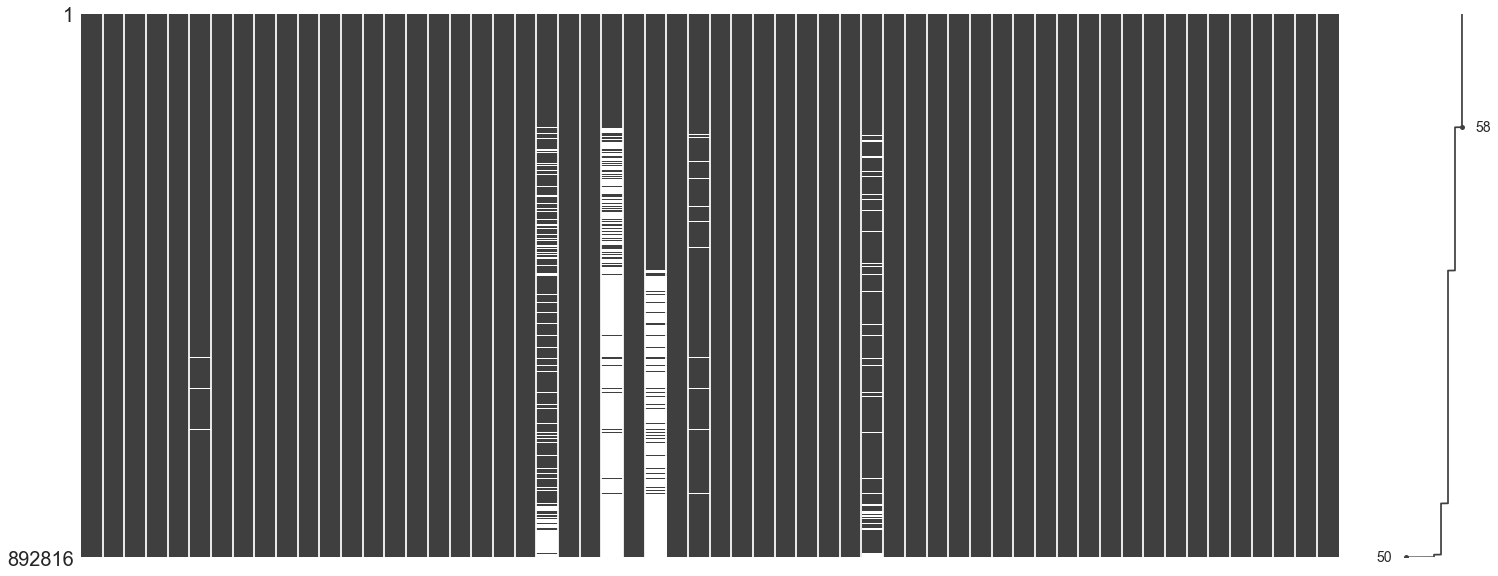

In [8]:
sorted_testdata = msn.nullity_sort(df_test2, sort='descending')
msn.matrix(sorted_testdata)

### Binary Features

In [9]:
binary_train = [c for c in df_train2.columns if c.endswith("bin")]
categorical_train = [c for c in df_train2.columns if c.endswith("cat")]

binary_test = [c for c in df_test2.columns if c.endswith("bin")]
categorical_test = [c for c in df_test2.columns if c.endswith("cat")]

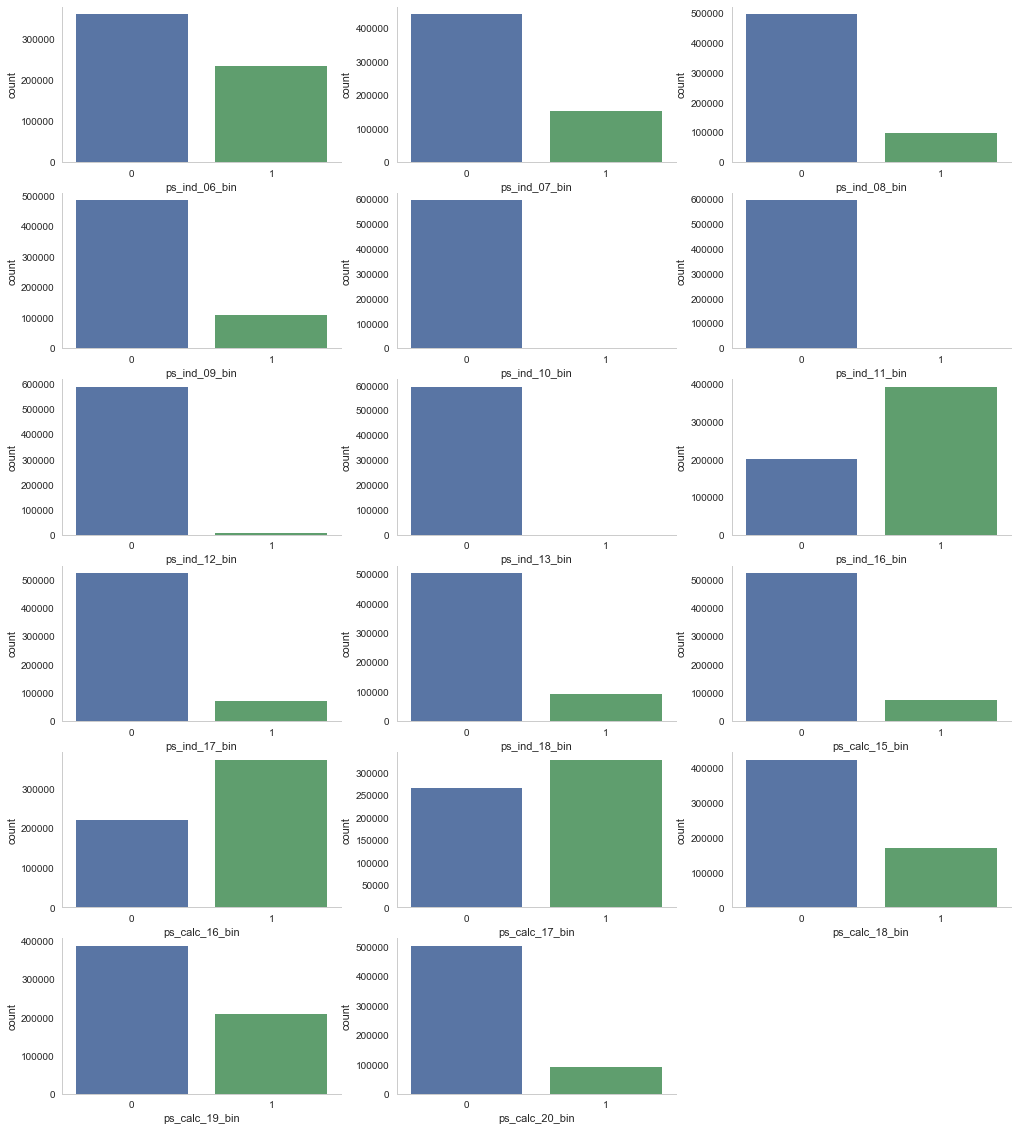

In [10]:
plt.figure(figsize=(17,20))
for i, c in enumerate(binary_train):
    ax = plt.subplot(6,3,i+1)
    sns.countplot(df_train2[c])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(False)

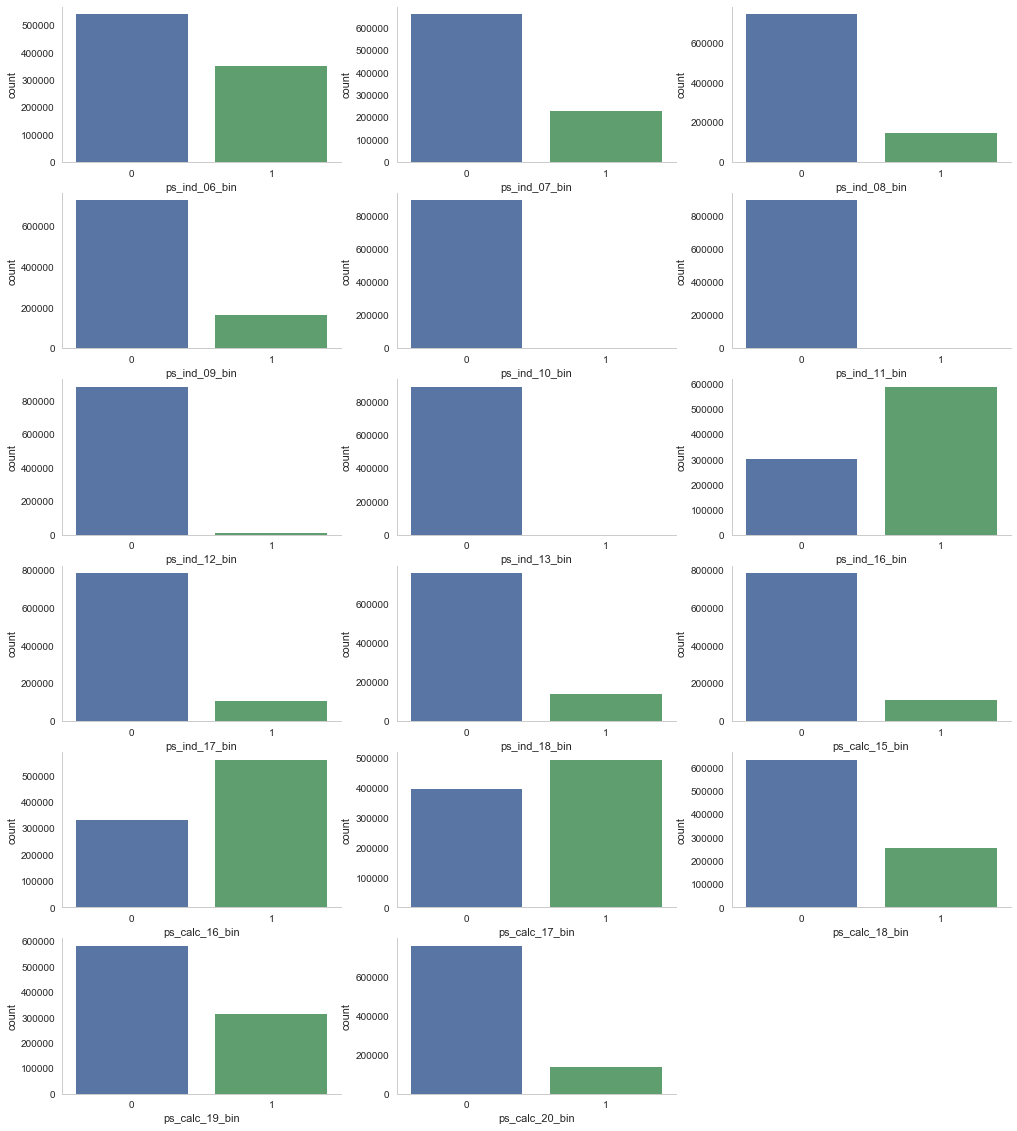

In [11]:
plt.figure(figsize=(17,20))
for i, c in enumerate(binary_test):
    ax = plt.subplot(6,3,i+1)
    sns.countplot(df_test2[c])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(False)

### Categorical Features

In [12]:
print("Training Data")
for i in categorical_train:
    print(i)
    print(df_train2[i].isnull().sum())
print('\n"Test Data')   
for i in categorical_test:
    print(i)
    print(df_test2[i].isnull().sum())

Training Data
ps_ind_02_cat
216
ps_ind_04_cat
83
ps_ind_05_cat
5809
ps_car_01_cat
107
ps_car_02_cat
5
ps_car_03_cat
411231
ps_car_04_cat
0
ps_car_05_cat
266551
ps_car_06_cat
0
ps_car_07_cat
11489
ps_car_08_cat
0
ps_car_09_cat
569
ps_car_10_cat
0
ps_car_11_cat
0

"Test Data
ps_ind_02_cat
307
ps_ind_04_cat
145
ps_ind_05_cat
8710
ps_car_01_cat
160
ps_car_02_cat
5
ps_car_03_cat
616911
ps_car_04_cat
0
ps_car_05_cat
400359
ps_car_06_cat
0
ps_car_07_cat
17331
ps_car_08_cat
0
ps_car_09_cat
877
ps_car_10_cat
0
ps_car_11_cat
0


### Ok looking at the categorical features we see that the both features with the very high percentage of missing attributes are located here and are namely: ps_car_03_cat and ps_car_05_cat. I will drop them for the moment. 

In [13]:
to_drop = ["ps_car_03_cat","ps_car_05_cat"]
df_train2.drop(to_drop, axis=1, inplace=True)
df_test2.drop(to_drop, axis=1, inplace=True)
categorical_train = [i for i in categorical_train if i not in to_drop]
categorical_test = [i for i in categorical_test if i not in to_drop]

In [14]:
for i in categorical_train:
    print(i)
    print(df_train2[i].value_counts())

ps_ind_02_cat
1.0    431859
2.0    123573
3.0     28186
4.0     11378
Name: ps_ind_02_cat, dtype: int64
ps_ind_04_cat
0.0    346965
1.0    248164
Name: ps_ind_04_cat, dtype: int64
ps_ind_05_cat
0.0    528009
6.0     20662
4.0     18344
1.0      8322
3.0      8233
2.0      4184
5.0      1649
Name: ps_ind_05_cat, dtype: int64
ps_car_01_cat
11.0    207573
7.0     179247
6.0      62393
10.0     50087
4.0      26174
9.0      20323
5.0      18142
8.0      15093
3.0       6658
0.0       5904
2.0       2144
1.0       1367
Name: ps_car_01_cat, dtype: int64
ps_car_02_cat
1.0    493990
0.0    101217
Name: ps_car_02_cat, dtype: int64
ps_car_04_cat
0    496581
1     32115
2     23770
8     20598
9     19034
6      1560
3       640
5       545
4       230
7       139
Name: ps_car_04_cat, dtype: int64
ps_car_06_cat
11    131527
1     118386
0     110420
14     59253
10     33466
4      31136
15     21732
6      20951
9      17617
7      16158
3      11997
13      6246
17      4935
16      4582
12    

### The following features are only binary in the train dataset. Is this also true for test data?

In [15]:
new_bin = ["ps_ind_04_cat","ps_car_02_cat","ps_car_07_cat", "ps_car_08_cat"]
for i in new_bin:
    print(i)
    print(df_test2[i].value_counts())

ps_ind_04_cat
0.0    519899
1.0    372772
Name: ps_ind_04_cat, dtype: int64
ps_car_02_cat
1.0    740989
0.0    151822
Name: ps_car_02_cat, dtype: int64
ps_car_07_cat
1.0    829922
0.0     45563
Name: ps_car_07_cat, dtype: int64
ps_car_08_cat
1    743101
0    149715
Name: ps_car_08_cat, dtype: int64


In [16]:
binary_train += new_bin
binary_test += new_bin
categorical_train = [i for i in categorical_train if i not in new_bin]
categorical_test = [i for i in categorical_test if i not in new_bin]

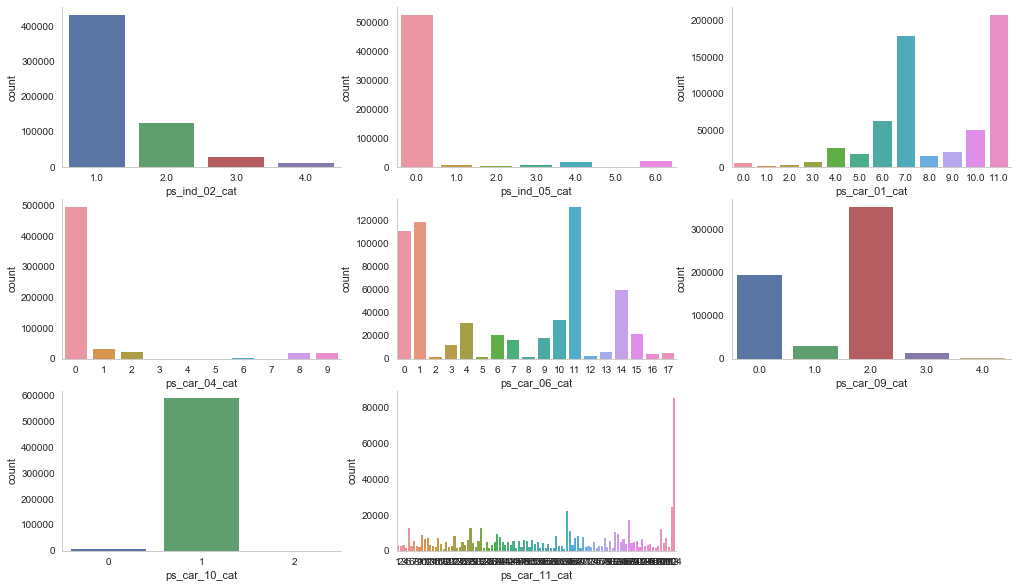

In [17]:
plt.figure(figsize=(17,10))
for i, c in enumerate(categorical_train):
    ax = plt.subplot(3,3,i+1)
    sns.countplot(df_train2[c])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(False)

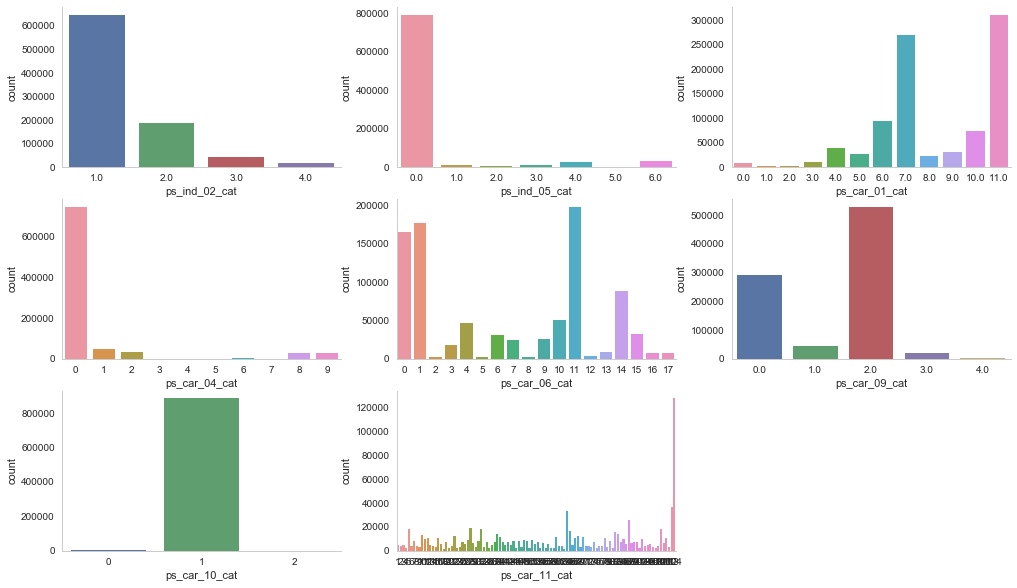

In [18]:
plt.figure(figsize=(17,10))
for i, c in enumerate(categorical_test):
    ax = plt.subplot(3,3,i+1)
    sns.countplot(df_test2[c])
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    plt.grid(False)

### We can impute the missing values with machine learning
#### First Binary ones

def split_data(df, feature, complete):
    """
    Here train and test sets of the df are generated
    Also the id row is dropped. 
    Has to be returned in the end
    """

    complete.append(feature)
    ids = df["id"]
    test_index = df[df[feature].isnull()].index
    train_index = [i for i in range(len(df)) if i not in test_index]
    train = df[complete].iloc[train_index]
    test = df[complete].iloc[test_index]

    X_train = train.drop([feature, "id"], axis=1)
    y_train = train[feature]
    X_test = test.drop([feature, "id"], axis=1)
    
    return X_train, y_train, X_test, ids
    

def logistic_imputation(df):
    """
    Input is dataframe and a list of features
    Function is:
        1. Looking if missing entries in features
        2. Looking for number of classes
        3. Splitting data 
        4. training on complete entries
        5. predicting missing values
        6. rebuild imputated df
    """
    predictions = []
    missing = [i for i in df if df[i].hasnans]
    
    for feature in missing:
        start = time.time()
        complete = [i for i in df if df[i].hasnans == False]
        print("Imputation for {}".format(feature))
        no_classes = len(df[feature].value_counts())
        
        X_train, y_train, X_test, ids = split_data(df, feature, complete) 
        
        print("{} has {} missing values.\nDataFrame was split in\ntrain set with length {} and\ntrain set with with length {}".format(feature, df[feature].isnull().sum(), len(X_train), len(X_test)))
        
        clf = LogisticRegression()
        print("Start training...")
        try:
            clf.fit(X_train, y_train)
            print("Start predicting...")
            pred = clf.predict(X_test)
        except:
            print("Error at {}".format(feature))
        predictions.append((feature, pred))
        print("Imputation of feature took {} s ".format(round(time.time()-start,2)))
        print("-"*75)
    return predictions

In [19]:
def split_data(df, feature, complete):
    """
    Here train and test sets of the df are generated
    Also the id row is dropped. 
    Has to be returned in the end
    """

    complete.append(feature)
    ids = df["id"]
    test_index = df[df[feature].isnull()].index
    train_index = [i for i in range(len(df)) if i not in test_index]
    train = df[complete].iloc[train_index]
    test = df[complete].iloc[test_index]

    X_train = train.drop([feature, "id"], axis=1)
    y_train = train[feature]
    X_test = test.drop([feature, "id"], axis=1)
    
    return X_train, y_train, X_test, ids
    

def svm_imputation(df):
    """
    Input is dataframe and a list of features
    Function is:
        1. Looking if missing entries in features
        2. Looking for number of classes
        3. Splitting data 
        4. training on complete entries
        5. predicting missing values
        6. rebuild imputated df
    """
    predictions = []
    missing = [i for i in df if df[i].hasnans]
    
    for feature in missing:
        start = time.time()
        complete = [i for i in df if df[i].hasnans == False]
        print("Imputation for {}".format(feature))
        no_classes = len(df[feature].value_counts())
        
        X_train, y_train, X_test, ids = split_data(df, feature, complete) 
        
        print("{} has {} missing values.\nDataFrame was split in\ntrain set with length {} and\ntrain set with with length {}".format(feature, df[feature].isnull().sum(), len(X_train), len(X_test)))
        
        clf = lgb.LGBMClassifier()
        print("Start training...")
        try:
            clf.fit(X_train, y_train)
            print("Start predicting...")
            pred = clf.predict(X_test)
        except:
            print("Error at {}".format(feature))
        predictions.append((feature, pred))
        print("Imputation of feature took {} s ".format(round(time.time()-start,2)))
        print("-"*75)
    return predictions

In [20]:
i_train = binary_train + categorical_train
i_test = binary_test + categorical_test
train_imputation = svm_imputation(df_train2[i_train+["id"]])
test_imputation = svm_imputation(df_test2[i_test+["id"]])

Imputation for ps_ind_04_cat
ps_ind_04_cat has 83 missing values.
DataFrame was split in
train set with length 595129 and
train set with with length 83
Start training...
Start predicting...
Imputation of feature took 5.04 s 
---------------------------------------------------------------------------
Imputation for ps_car_02_cat
ps_car_02_cat has 5 missing values.
DataFrame was split in
train set with length 595207 and
train set with with length 5
Start training...
Start predicting...
Imputation of feature took 2.25 s 
---------------------------------------------------------------------------
Imputation for ps_car_07_cat
ps_car_07_cat has 11489 missing values.
DataFrame was split in
train set with length 583723 and
train set with with length 11489
Start training...
Start predicting...
Imputation of feature took 2.04 s 
---------------------------------------------------------------------------
Imputation for ps_ind_02_cat
ps_ind_02_cat has 216 missing values.
DataFrame was split in
tra

import csv
with open('train_imputation.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for i in train_imputation:
        writer.writerow(i)
with open('test_imputation.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    for i in test_imputation:
        writer.writerow(i)        

In [21]:
def replace_values(df, imputation):
    print("Start replacement...")
    index = []
    for imp in imputation:
        index.append((imp[0], imp[1], df[imp[0]][df[imp[0]].isnull()].index))
    for i in index:
        df[i[0]].iloc[i[2]] = i[1]
    return df        

import csv
train_imputation = []
with open('train_imputation.csv', 'r', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    for i in reader:
        train_imputation.append(i)
        
test_imputation = []     
with open('test_imputation.csv', 'r', newline='') as f:
    reader = csv.reader(f, delimiter=',')
    for i in reader:
        test_imputation.append(i)   

In [22]:
df_train3 = replace_values(df_train2, train_imputation)
df_test3 = replace_values(df_test2, test_imputation)

Start replacement...


C:\Users\Wegee\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Start replacement...


In [23]:
#ok we have kinda the prob that we dont have proper copys of the dataframes but all are mushed together >_<
df_train3.to_csv("partially_imputated_train.csv")
df_test3.to_csv("partially_imputated_test.csv")

df_train3 = pd.read_csv("partially_imputated_train.csv")
df_test3 = pd.read_csv("partially_imputated_test.csv")

In [24]:
def split_data(df, feature, complete):
    """
    Here train and test sets of the df are generated
    Also the id row is dropped. 
    Has to be returned in the end
    """

    complete.append(feature)
    ids = df["id"]
    test_index = df[df[feature].isnull()].index
    train_index = [i for i in range(len(df)) if i not in test_index]
    train = df[complete].iloc[train_index]
    test = df[complete].iloc[test_index]

    X_train = train.drop([feature, "id"], axis=1)
    y_train = train[feature]
    X_test = test.drop([feature, "id"], axis=1)
    
    return X_train, y_train, X_test, ids
    

def linear_imputation(df):
    """
    Input is dataframe and a list of features
    Function is:
        1. Looking if missing entries in features
        2. Looking for number of classes
        3. Splitting data 
        4. training on complete entries
        5. predicting missing values
        6. rebuild imputated df
    """
    predictions = []
    missing = [i for i in df if df[i].hasnans]
    
    for feature in missing:
        start = time.time()
        complete = [i for i in df if df[i].hasnans == False]
        print("Imputation for {}".format(feature))
        no_classes = len(df[feature].value_counts())
        
        X_train, y_train, X_test, ids = split_data(df, feature, complete) 
        
        print("{} has {} missing values.\nDataFrame was split in\ntrain set with length {} and\ntrain set with with length {}".format(feature, df[feature].isnull().sum(), len(X_train), len(X_test)))
        
        clf = LinearRegression()
        print("Start training...")
        
        clf.fit(X_train, y_train)
        print("Start predicting...")
        pred = clf.predict(X_test)
        predictions.append((feature, pred))
        print("Imputation of feature took {} s ".format(round(time.time()-start,2)))
        print("-"*75)
    return predictions

In [25]:
i_train = [i for i in df_train3.columns if i not in (binary_train + categorical_train)]
i_test = [i for i in df_test3.columns if i not in (binary_test + categorical_test)]
train_imputation = linear_imputation(df_train3[i_train])
test_imputation = linear_imputation(df_test3[i_test])

Imputation for ps_reg_03
ps_reg_03 has 107772 missing values.
DataFrame was split in
train set with length 487440 and
train set with with length 107772
Start training...
Start predicting...
Imputation of feature took 6.15 s 
---------------------------------------------------------------------------
Imputation for ps_car_11
ps_car_11 has 5 missing values.
DataFrame was split in
train set with length 595207 and
train set with with length 5
Start training...
Start predicting...
Imputation of feature took 1.72 s 
---------------------------------------------------------------------------
Imputation for ps_car_12
ps_car_12 has 1 missing values.
DataFrame was split in
train set with length 595211 and
train set with with length 1
Start training...
Start predicting...
Imputation of feature took 1.86 s 
---------------------------------------------------------------------------
Imputation for ps_car_14
ps_car_14 has 42620 missing values.
DataFrame was split in
train set with length 552592 and


In [26]:
df_train3 = replace_values(df_train3, train_imputation)
df_test3 = replace_values(df_test3, test_imputation)

Start replacement...


C:\Users\Wegee\Anaconda3\lib\site-packages\pandas\core\indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Start replacement...


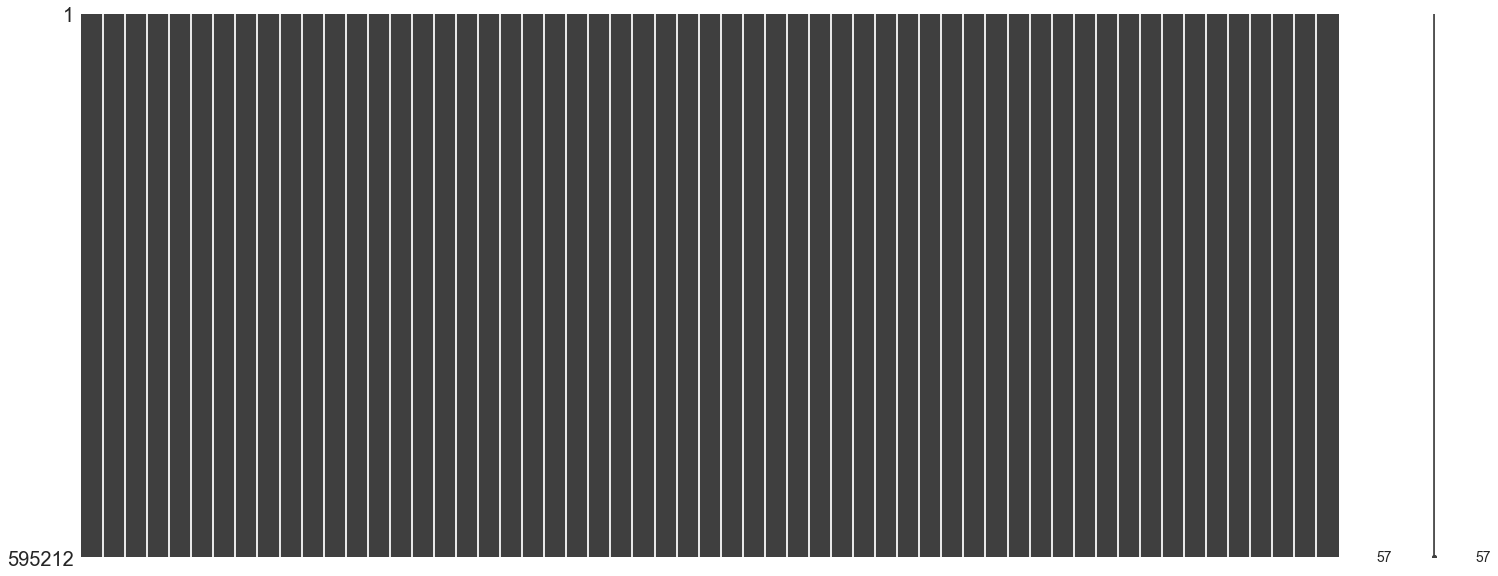

In [41]:
msn.matrix(df_train3)

### Ok in a first attempt let's just impute the missing values with the most common one

In [42]:
enc = OneHotEncoder()
enc.fit_transform(df_train3[categorical_train])
enc.fit_transform(df_test3[categorical_test])

<892816x163 sparse matrix of type '<class 'numpy.float64'>'
	with 7142528 stored elements in Compressed Sparse Row format>

In [43]:
df_train3.to_csv("train_impuatated.csv")
df_test3.to_csv("test_imputated.csv")

### Continuous features

In [29]:
continuous_train = [i for i in df_train3.columns if 
                    ((i not in binary_train) and (i not in categorical_train) and (i not in ["target", "id"]))]
continuous_test = [i for i in df_test3.columns if 
                   ((i not in binary_test) and (i not in categorical_test) and (i != "id"))]

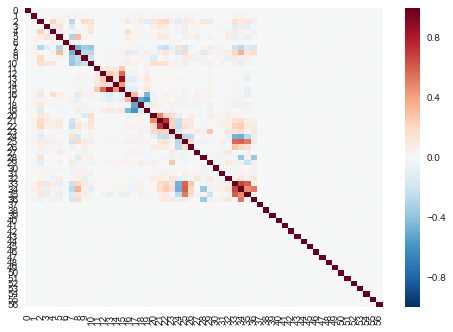

In [30]:
corr = np.corrcoef(df_train3.transpose())
sns.heatmap(corr)

C:\Users\Wegee\Anaconda3\lib\site-packages\matplotlib\cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


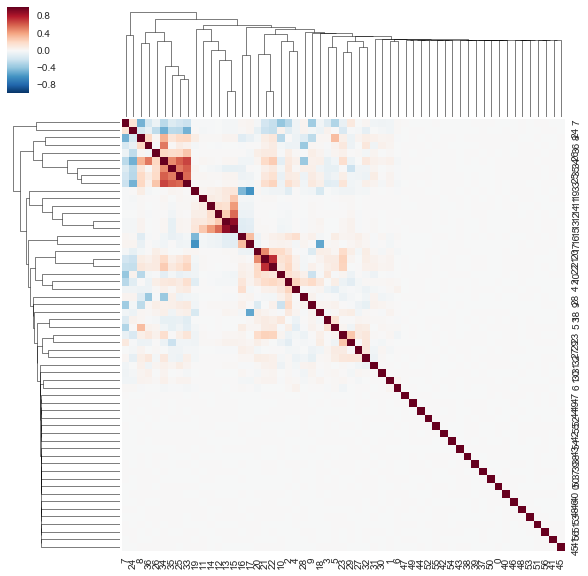

In [31]:
sns.clustermap(corr)

## To be continued... :D

In [107]:
gc.collect()

2020

### Ok enough with the EDA, time to do some predictions

In [108]:
#The function used in most kernels
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
    
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)


#SKlearn
gini_sklearn = metrics.make_scorer(gini_normalizedc, True, True)

In [58]:
df_train3.drop(["ps_calc_04","ps_calc_02","ps_calc_08","ps_calc_05","ps_calc_12","ps_calc_10","ps_calc_06","ps_calc_13","ps_calc_15_bin","ps_calc_17_bin",
"ps_calc_19_bin", "ps_calc_16_bin", "ps_car_08_cat", "ps_car_02_cat", "ps_ind_12_bin","ps_ind_18_bin"], axis=1, inplace=True)
df_test3.drop(["ps_calc_04","ps_calc_02","ps_calc_08","ps_calc_05","ps_calc_12","ps_calc_10","ps_calc_06","ps_calc_13","ps_calc_15_bin","ps_calc_17_bin",
"ps_calc_19_bin", "ps_calc_16_bin", "ps_car_08_cat", "ps_car_02_cat", "ps_ind_12_bin","ps_ind_18_bin"], axis=1, inplace=True)

In [102]:
X = df_train3.drop(["id", "target"], axis=1)
y = df_train3["target"]

traincol = df_train3.columns

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.1, 
                                                    random_state=1337)

print("Format train and validation set for LGB")
d_train = lgb.Dataset(X_train, label=y_train)
d_val = lgb.Dataset(X_test, label=y_test)

Format train and validation set for LGB


In [37]:
params = {'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.05, 
    'max_depth': 5,
    'num_iterations': 5000, 
    'num_leaves': 90, 
    'min_data_in_leaf': 50, 
    'lambda_l1': 1.0,
    'feature_fraction': 0.8, 
    'bagging_fraction': 0.8, 
    'bagging_freq': 5}

rnds = 1000

mod = lgb.train(params, train_set=d_train, num_boost_round = rnds,
               valid_sets=[d_val], valid_names=['dval'], verbose_eval=20,
               early_stopping_rounds=20)
"""
estimator = lgb.LGBMClassifier()

param_grid = {'task': ['train'],
    'boosting_type': ['gbdt'],
    'objective': ['binary'],
    'metric': ['binary_logloss'],
    'learning_rate': [0.05], 
    'max_depth': [3,5,7],
    'num_iterations': [1000], 
    'num_leaves': [90,100], 
    'min_data_in_leaf': [50,100,200], 
    'lambda_l1': [1.0],
    'feature_fraction': [0.8], 
    'bagging_fraction': [0.8], 
    'bagging_freq': [5]}

gbm = GridSearchCV(estimator, param_grid)
gbm.fit(X_train, y_train)

print('Best parameters found by grid search are:', gbm.best_params_)
"""

C:\Users\Wegee\Anaconda3\lib\site-packages\lightgbm\engine.py:100: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 20 rounds.
[20]	dval's binary_logloss: 0.277638
[40]	dval's binary_logloss: 0.182181
[60]	dval's binary_logloss: 0.158895
[80]	dval's binary_logloss: 0.153772
[100]	dval's binary_logloss: 0.152643
[120]	dval's binary_logloss: 0.1522
[140]	dval's binary_logloss: 0.151971
[160]	dval's binary_logloss: 0.151863
[180]	dval's binary_logloss: 0.15178
[200]	dval's binary_logloss: 0.151775
[220]	dval's binary_logloss: 0.151778
[240]	dval's binary_logloss: 0.151761
[260]	dval's binary_logloss: 0.151732
[280]	dval's binary_logloss: 0.151684
[300]	dval's binary_logloss: 0.151654
[320]	dval's binary_logloss: 0.151675
Early stopping, best iteration is:
[305]	dval's binary_logloss: 0.151649


"\nestimator = lgb.LGBMClassifier()\n\nparam_grid = {'task': ['train'],\n    'boosting_type': ['gbdt'],\n    'objective': ['binary'],\n    'metric': ['binary_logloss'],\n    'learning_rate': [0.05], \n    'max_depth': [3,5,7],\n    'num_iterations': [1000], \n    'num_leaves': [90,100], \n    'min_data_in_leaf': [50,100,200], \n    'lambda_l1': [1.0],\n    'feature_fraction': [0.8], \n    'bagging_fraction': [0.8], \n    'bagging_freq': [5]}\n\ngbm = GridSearchCV(estimator, param_grid)\ngbm.fit(X_train, y_train)\n\nprint('Best parameters found by grid search are:', gbm.best_params_)\n"

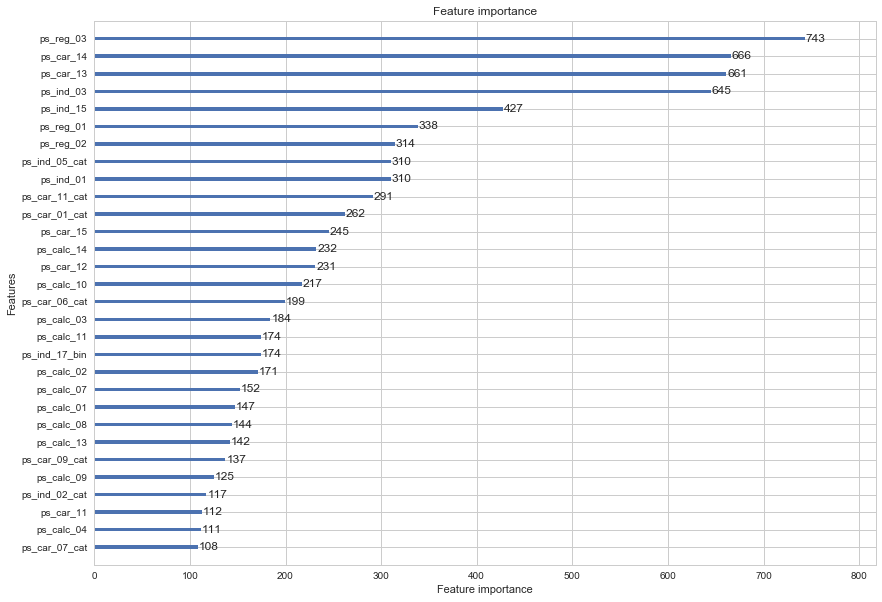

In [38]:
lgb.plot_importance(mod, max_num_features=30, figsize=(14,10))

In [39]:
pred = mod.predict(df_test3.drop("id", axis=1))

In [40]:
pred = [min(i) for i in pred]

TypeError: 'numpy.float64' object is not iterable

In [ ]:
sub = pd.DataFrame()
sub["id"] = df_test3["id"]
sub["target"] = pred
sub.head()

In [ ]:
now = datetime.datetime.now()
sub.to_csv('LGB_partialImputation_{}.csv'.format(now.strftime("%Y-%m-%d-%H-%M")), index=False)

In [94]:
est = xgb.XGBClassifier(#max_depth=3, 
                        learning_rate=0.05, 
                        n_estimators=200, 
                        silent=False, 
                        objective='binary:logistic', 
                        booster='gbtree', 
                        n_jobs=1, 
                        nthread=None, 
                        gamma=0, 
                        #min_child_weight=2.5, 
                        max_delta_step=0, 
                        subsample=0.8, 
                        colsample_bytree=0.8,
                        random_state=1337, 
                        )

In [67]:
params = {"max_depth" : [3,4,5],
          "min_child_weight" : [1,2.5,5]}
clf = GridSearchCV(est, params)

In [71]:
clf.best_params_

{'max_depth': 4, 'min_child_weight': 1}

In [95]:
clf = xgb.XGBClassifier(max_depth=4, 
                        learning_rate=0.02, 
                        n_estimators=2000, 
                        silent=False, 
                        objective='binary:logistic', 
                        booster='gbtree',
                        eval_metric= 'auc',
                        n_jobs=1, 
                        nthread=None, 
                        gamma=0, 
                        min_child_weight=1, 
                        max_delta_step=0, 
                        subsample=0.9, 
                        colsample_bytree=0.9,
                        random_state=1337, 
                        )

In [111]:
search1 = GridSearchCV(estimator = xgb.XGBClassifier( 
        objective= 'binary:logistic', 
        seed=1), 
        param_grid = params, 
        scoring = gini_sklearn,
        cv=10,
        verbose = 1)

ValueError: Parameter values for parameter (eta) need to be a sequence(but not a string) or np.ndarray.

In [80]:
clf.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
       eval_metric=gini_xgb, verbose=20, early_stopping_rounds=20)

[0]	validation_0-error:0.036445	validation_1-error:0.036474	validation_0-gini:0.18581	validation_1-gini:0.183539
Multiple eval metrics have been passed: 'validation_1-gini' will be used for early stopping.

Will train until validation_1-gini hasn't improved in 20 rounds.
[20]	validation_0-error:0.036445	validation_1-error:0.036474	validation_0-gini:0.240679	validation_1-gini:0.243986
Stopping. Best iteration:
[0]	validation_0-error:0.036445	validation_1-error:0.036474	validation_0-gini:0.18581	validation_1-gini:0.183539



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=2000,
       n_jobs=1, nthread=None, objective='binary:logistic',
       random_state=1337, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=False, subsample=0.8)

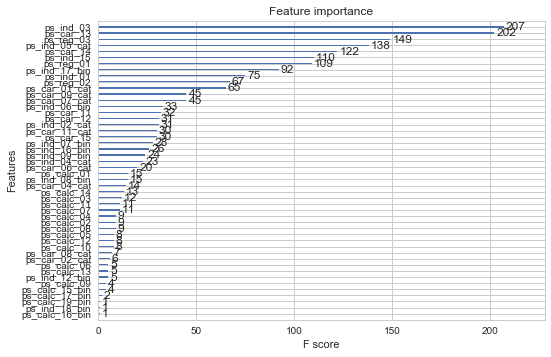

In [52]:
xgb.plot_importance(clf)

In [90]:
pred = xgb_model.predict(df_test3.drop("id", axis=1))

AttributeError: 'DataFrame' object has no attribute 'feature_names'

In [82]:
pred = [min(i) for i in pred]

In [83]:
sub = pd.DataFrame()
sub["id"] = df_test["id"]
sub["target"] = pred
sub.head()

,id,target
0,0,0.189329
1,1,0.190880
2,2,0.197434
3,3,0.188109
4,4,0.193846


In [84]:
now = datetime.datetime.now()
sub.to_csv('XGB_naive_{}.csv'.format(now.strftime("%Y-%m-%d-%H-%M")), index=False)